In [1]:
import  warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

%matplotlib inline
plt.style.use('ggplot')

# Load Dataset

In [2]:
test = pd.read_csv('test_table.csv', parse_dates=['date'])
test.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1


In [3]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453321 entries, 0 to 453320
Data columns (total 9 columns):
user_id             453321 non-null int64
date                453321 non-null datetime64[ns]
source              453321 non-null object
device              453321 non-null object
browser_language    453321 non-null object
ads_channel         181877 non-null object
browser             453321 non-null object
conversion          453321 non-null int64
test                453321 non-null int64
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 31.1+ MB


In [4]:
test.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
user_id,453321.0,499937.514728,288665.193436,1.0,249816.0,500019.0,749522.0,1000000.0
conversion,453321.0,0.049579,0.217073,0.0,0.0,0.0,0.0,1.0
test,453321.0,0.476446,0.499445,0.0,0.0,0.0,1.0,1.0


In [5]:
user = pd.read_csv('user_table.csv')
user.head()

,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia
3,987753,F,27,Venezuela
4,554597,F,20,Spain


In [6]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452867 entries, 0 to 452866
Data columns (total 4 columns):
user_id    452867 non-null int64
sex        452867 non-null object
age        452867 non-null int64
country    452867 non-null object
dtypes: int64(2), object(2)
memory usage: 13.8+ MB


In [7]:
user.describe()

,user_id,age
count,452867.000000,452867.000000
mean,499944.805166,27.130740
std,288676.264784,6.776678
min,1.000000,18.000000
25%,249819.000000,22.000000
50%,500019.000000,26.000000
75%,749543.000000,31.000000
max,1000000.000000,70.000000


In [8]:
# Check uniqueness
print('Test ID:\t', len(test['user_id'].unique()), '\t', len(test['user_id'].unique()) == len(test))
print('User ID:\t', len(user['user_id'].unique()), '\t', len(user['user_id'].unique()) == len(user)) 

Test ID:	 453321 	 True
User ID:	 452867 	 True


In [9]:
# Merge two tables
data = pd.merge(left=test, right=user, how='left', on='user_id')
data.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0,M,32.0,Spain
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21.0,Mexico
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0,M,34.0,Spain
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22.0,Mexico
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19.0,Mexico


In [10]:
len(data)

453321

In [67]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 453321 entries, 0 to 453320
Data columns (total 12 columns):
user_id             453321 non-null int64
date                453321 non-null datetime64[ns]
source              453321 non-null object
device              453321 non-null object
browser_language    453321 non-null object
ads_channel         181877 non-null object
browser             453321 non-null object
conversion          453321 non-null int64
test                453321 non-null int64
sex                 452867 non-null object
age                 452867 non-null float64
country             452867 non-null object
dtypes: datetime64[ns](1), float64(1), int64(3), object(7)
memory usage: 45.0+ MB


# A/B Test

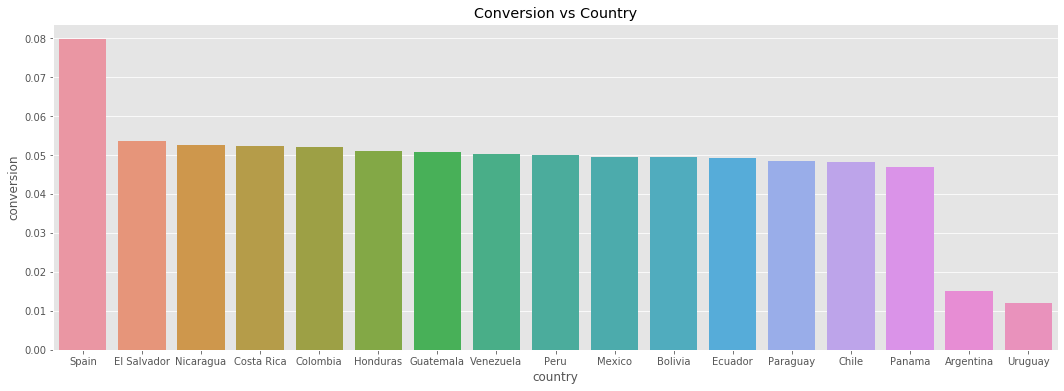

In [16]:
# First check that Spain converts much better than the rest of LatAm countries
groupby_country = data[data['test'] == 0][['conversion', 'country']].groupby('country').mean()
groupby_country = groupby_country.reset_index()
groupby_country = groupby_country.sort_values('conversion', ascending=False)

# Visualization
fig, ax = plt.subplots(figsize=(18, 6))
sns.barplot(x='country', y='conversion', data=groupby_country, ax=ax)
plt.title("Conversion vs Country")
plt.show()

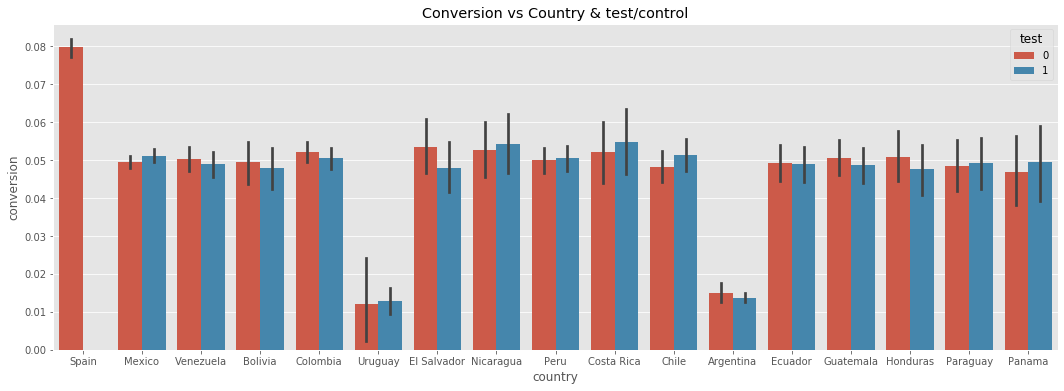

In [15]:
# Visualization
fig, ax = plt.subplots(figsize=(18, 6))
sns.barplot(x='country', y='conversion', hue='test', data=data, ax=ax)
plt.title("Conversion vs Country & test/control")
plt.show()

In [21]:
# A/B test: control group saw old version (0), test/experiment group saw new version (1)
test_data = data[data['country'] != 'Spain']
test_val = test_data[test_data['test'] == 1]['conversion']
cont_val = test_data[test_data['test'] == 0]['conversion']

print("mean conversion rate of test: ",round(test_val.mean(),5)) 
print("mean conversion rate of control: ",round(cont_val.mean(),5))

mean conversion rate of test:  0.04342
mean conversion rate of control:  0.04833


In [24]:
test_val.var(), cont_val.var()

(0.041539200524059544, 0.045994841233679556)

In [22]:
print(len(test_val),len(cont_val))

215983 185556


In [78]:
# We assume test/control groups NOT equal population variance, 
# So perform Welch's t-test and set equal_var=False
print(ttest_ind(test_val, cont_val, equal_var=False))

Ttest_indResult(statistic=-7.3939374121344805, pvalue=1.4282994754055316e-13)


In [25]:
# We assume test/control groups equal population variance, 
# So perform Welch's t-test and set equal_var=True
print(ttest_ind(test_val, cont_val, equal_var=True))

Ttest_indResult(statistic=-7.422512095954769, pvalue=1.15144687852198e-13)


### Well, it seems that local-translation make it even worse

# Analysis

In [27]:
data = data[data['country'] != 'Spain']
data.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21.0,Mexico
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22.0,Mexico
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19.0,Mexico
5,540675,2015-12-03,Direct,Mobile,ES,NaN,Android_App,0,1,F,22.0,Venezuela
6,863394,2015-12-04,SEO,Mobile,Other,NaN,Android_App,0,0,M,35.0,Mexico


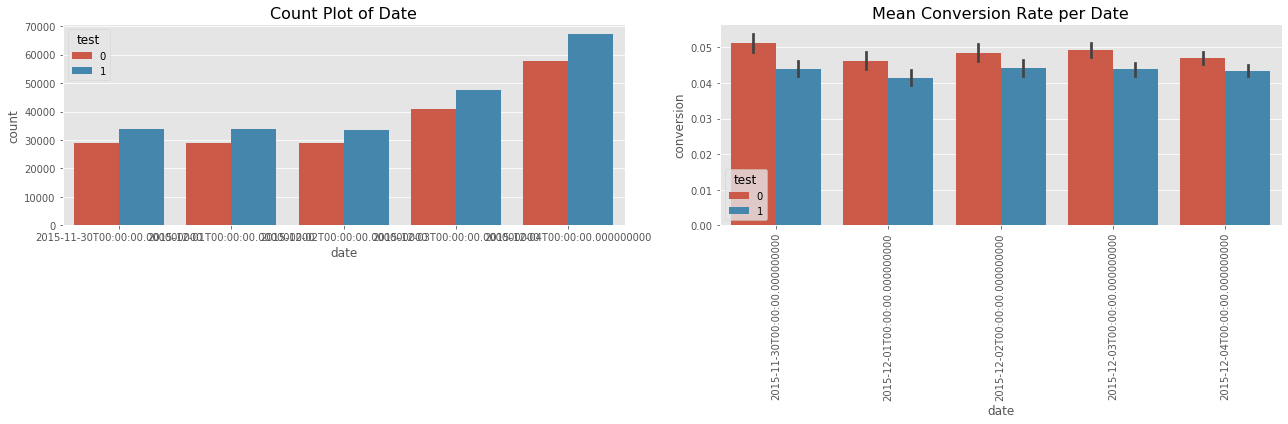

In [28]:
# Visualization of different dates
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

sns.countplot(x='date', hue='test', data=data, ax=ax[0])
ax[0].set_title('Count Plot of Date', fontsize=16)

plt.xticks(rotation=90)
sns.barplot(x='date', y='conversion', hue='test', data=data, ax=ax[1])
ax[1].set_title('Mean Conversion Rate per Date', fontsize=16)

plt.tight_layout()
plt.show()

In [29]:
data.groupby(['date'])['conversion'].value_counts()

date        conversion
2015-11-30  0              59925
            1               2978
2015-12-01  0              60165
            1               2746
2015-12-02  0              59599
            1               2889
2015-12-03  0              84113
            1               4091
2015-12-04  0             119390
            1               5643
Name: conversion, dtype: int64

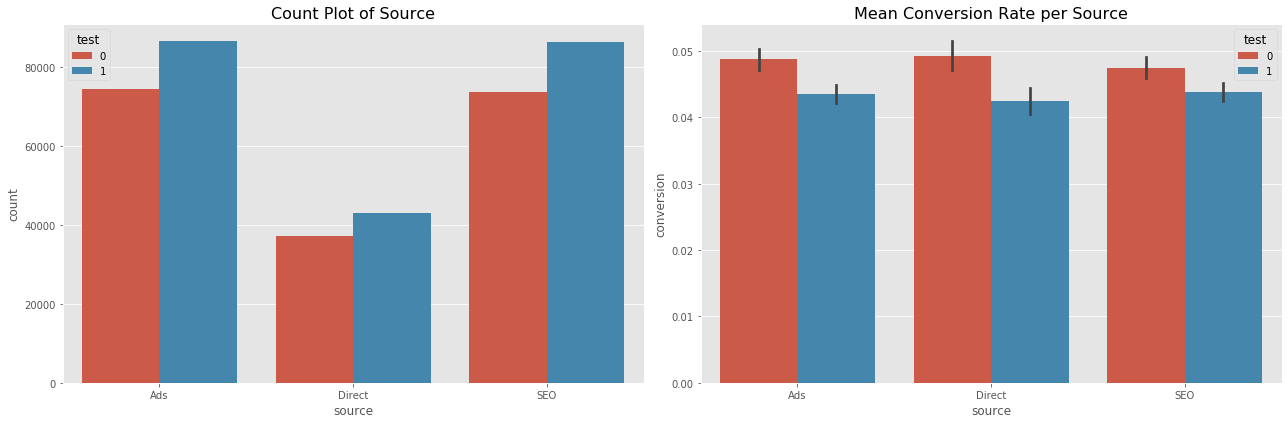

In [30]:
# Visualization of different source
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='source', hue='test', data=data, ax=ax[0])
ax[0].set_title('Count Plot of Source', fontsize=16)

sns.barplot(x='source', y='conversion', hue='test', data=data, ax=ax[1])
ax[1].set_title('Mean Conversion Rate per Source', fontsize=16)
plt.tight_layout()
plt.show()

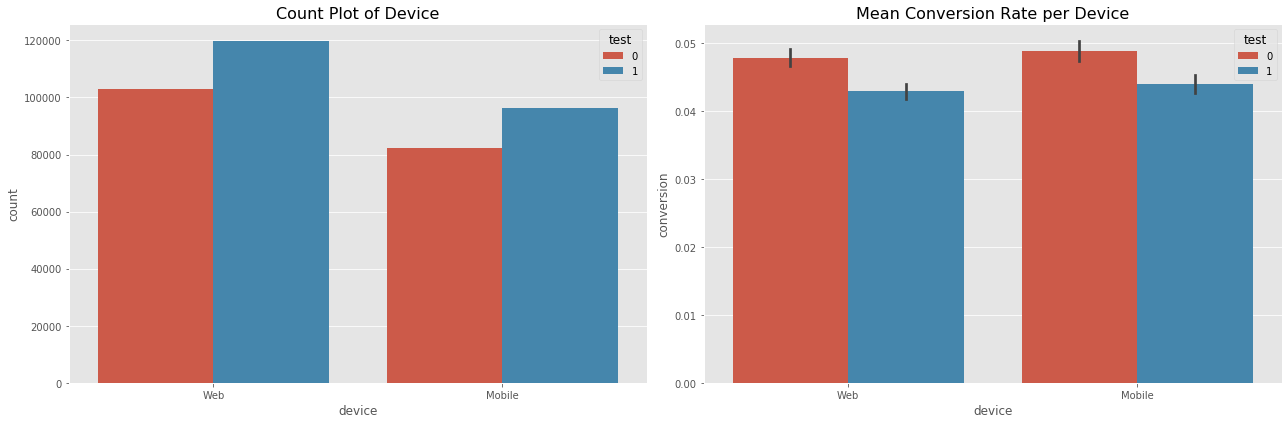

In [31]:
# Visualization of different devices
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='device', hue='test', data=data, ax=ax[0])
ax[0].set_title('Count Plot of Device', fontsize=16)

sns.barplot(x='device', y='conversion', hue='test', data=data, ax=ax[1])
ax[1].set_title('Mean Conversion Rate per Device', fontsize=16)
plt.tight_layout()
plt.show()

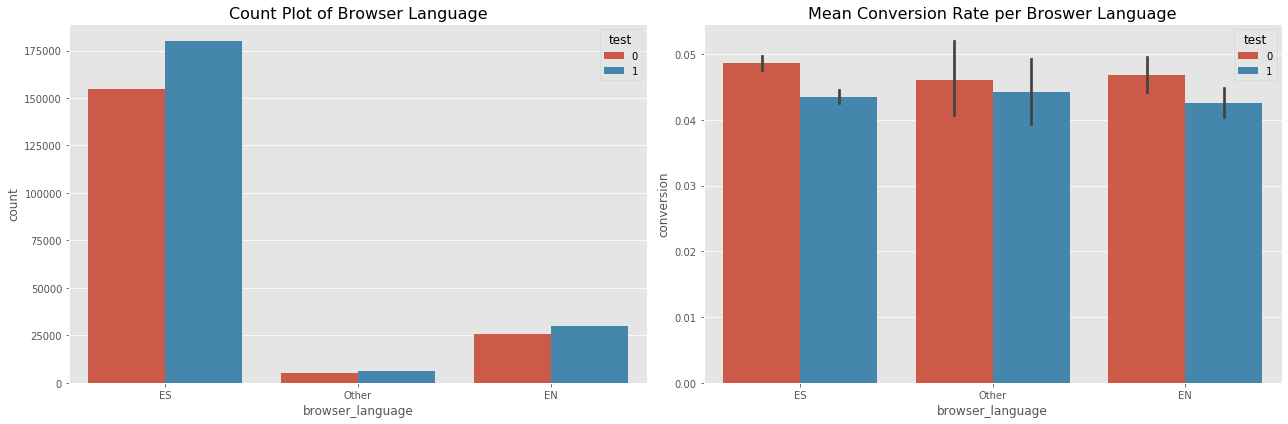

In [32]:
# Visualization of different languages
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='browser_language', hue='test', data=data, ax=ax[0])
ax[0].set_title('Count Plot of Browser Language', fontsize=16)

sns.barplot(x='browser_language', y='conversion', hue='test', data=data, ax=ax[1])
ax[1].set_title('Mean Conversion Rate per Broswer Language', fontsize=16)
plt.tight_layout()
plt.show()

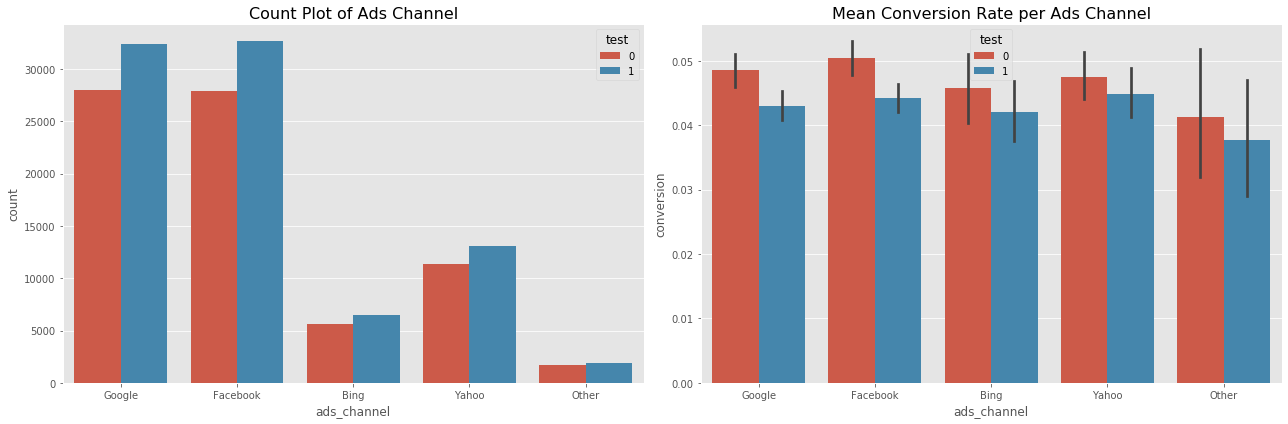

In [34]:
# Visualization of different ads channels
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='ads_channel', hue='test', data=data, ax=ax[0])
ax[0].set_title('Count Plot of Ads Channel', fontsize=16)

sns.barplot(x='ads_channel', y='conversion', hue='test', data=data, ax=ax[1])
ax[1].set_title('Mean Conversion Rate per Ads Channel', fontsize=16)
plt.tight_layout()
plt.show()

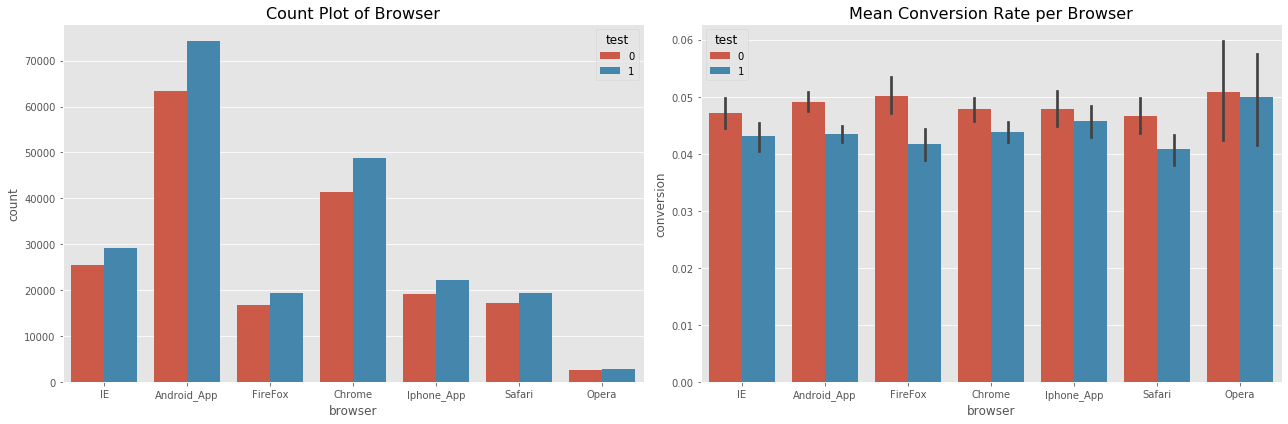

In [35]:
# Visualization of different browsers
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='browser', hue='test', data=data, ax=ax[0])
ax[0].set_title('Count Plot of Browser', fontsize=16)

sns.barplot(x='browser', y='conversion', hue='test', data=data, ax=ax[1])
ax[1].set_title('Mean Conversion Rate per Browser', fontsize=16)
plt.tight_layout()
plt.show()

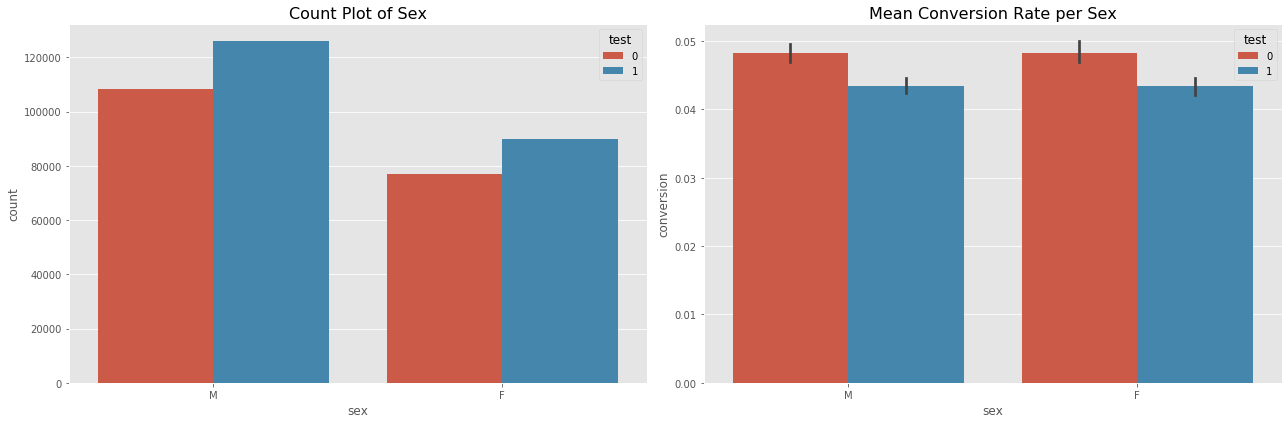

In [36]:
# Visualization of different genders
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='sex', hue='test', data=data, ax=ax[0])
ax[0].set_title('Count Plot of Sex', fontsize=16)

sns.barplot(x='sex', y='conversion', hue='test', data=data, ax=ax[1])
ax[1].set_title('Mean Conversion Rate per Sex', fontsize=16)
plt.tight_layout()
plt.show()

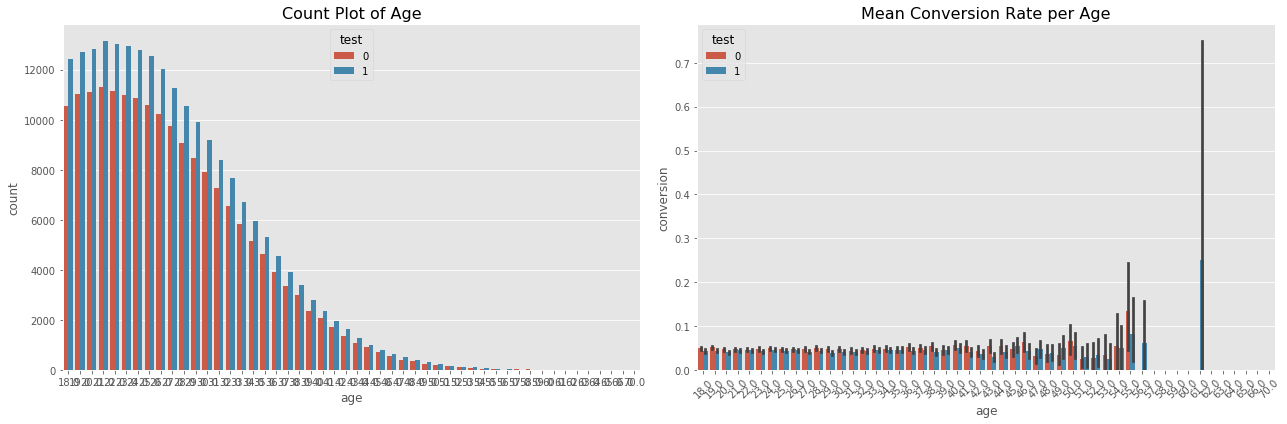

In [37]:
# Visualization of different ages
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='age', hue='test', data=data, ax=ax[0])
ax[0].set_title('Count Plot of Age', fontsize=16)

sns.barplot(x='age', y='conversion', hue='test', data=data, ax=ax[1])
ax[1].set_title('Mean Conversion Rate per Age', fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

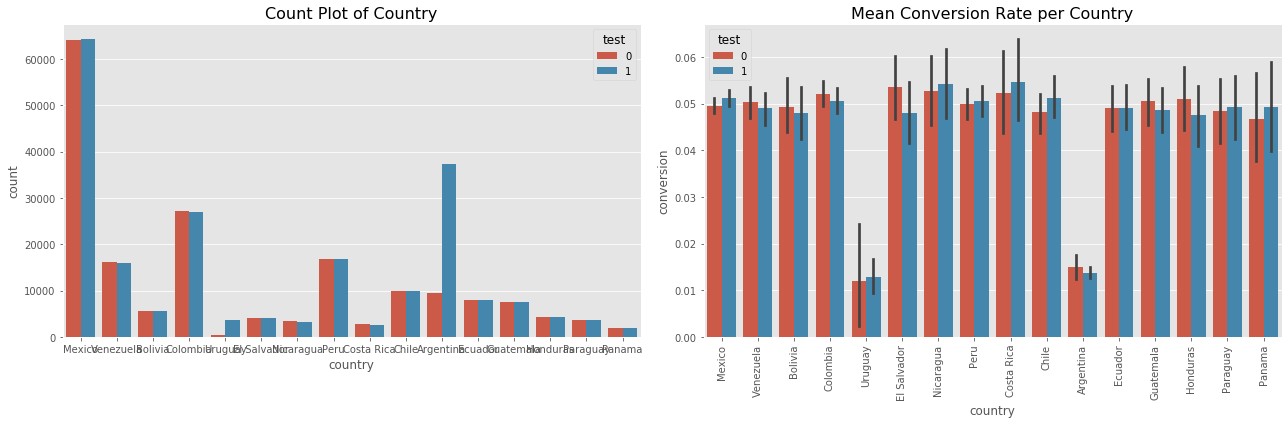

In [39]:
# Visualization of different countries
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='country', hue='test', data=data, ax=ax[0])
ax[0].set_title('Count Plot of Country', fontsize=16)

sns.barplot(x='country', y='conversion', hue='test', data=data, ax=ax[1])
ax[1].set_title('Mean Conversion Rate per Country', fontsize=16)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Now, let check for each country

In [40]:
countries = [name for name in data['country'].unique() if name is not np.nan]
countries

['Mexico',
 'Venezuela',
 'Bolivia',
 'Colombia',
 'Uruguay',
 'El Salvador',
 'Nicaragua',
 'Peru',
 'Costa Rica',
 'Chile',
 'Argentina',
 'Ecuador',
 'Guatemala',
 'Honduras',
 'Paraguay',
 'Panama']

In [41]:
countries = [name for name in data['country'].unique() if name is not np.nan]

print('{0:15s} {1:>15s} {2:>15s} {3:>10s}'.format('Country', 'Test Rate', 'Control Rate', 'P-Value'))
print('-' * 65)
for country in countries:
    test_val = data[(data['country'] == country) & (data['test'] == 1)]['conversion']
    cont_val = data[(data['country'] == country) & (data['test'] == 0)]['conversion']
    
    test_mean = test_val.mean()
    cont_mean = cont_val.mean()
    p_val = ttest_ind(test_val, cont_val, equal_var=False).pvalue
    
    print('{0:15s} {1:15.5f} {2:15.5f} {3:10f}'.format(country, test_mean, cont_mean, p_val))

Country               Test Rate    Control Rate    P-Value
-----------------------------------------------------------------
Mexico                  0.05119         0.04949   0.165544
Venezuela               0.04898         0.05034   0.573702
Bolivia                 0.04790         0.04937   0.718885
Colombia                0.05057         0.05209   0.423719
Uruguay                 0.01291         0.01205   0.879764
El Salvador             0.04795         0.05355   0.248127
Nicaragua               0.05418         0.05265   0.780400
Peru                    0.05060         0.04991   0.771953
Costa Rica              0.05474         0.05226   0.687876
Chile                   0.05130         0.04811   0.302848
Argentina               0.01373         0.01507   0.335147
Ecuador                 0.04899         0.04915   0.961512
Guatemala               0.04865         0.05064   0.572107
Honduras                0.04754         0.05091   0.471463
Paraguay                0.04923         0.04849  